In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import pandas as pd
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [3]:
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
img_path = str(pathlib.Path.cwd()) + "/test/" + "elephant.jpg"

In [5]:
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor /= 255.
img_tensor = preprocess_input(img_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


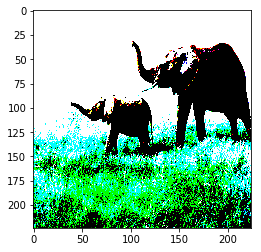

In [6]:
plt.imshow(img_tensor[0])

In [7]:
preds = model.predict(img_tensor)
pred_label_keras = np.argmax(preds, axis=1)
print(str(pred_label_keras))

[386]


In [8]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.89975667), ('n01871265', 'tusker', 0.0934482), ('n02504013', 'Indian_elephant', 0.0062752725)]


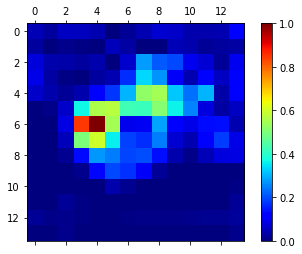

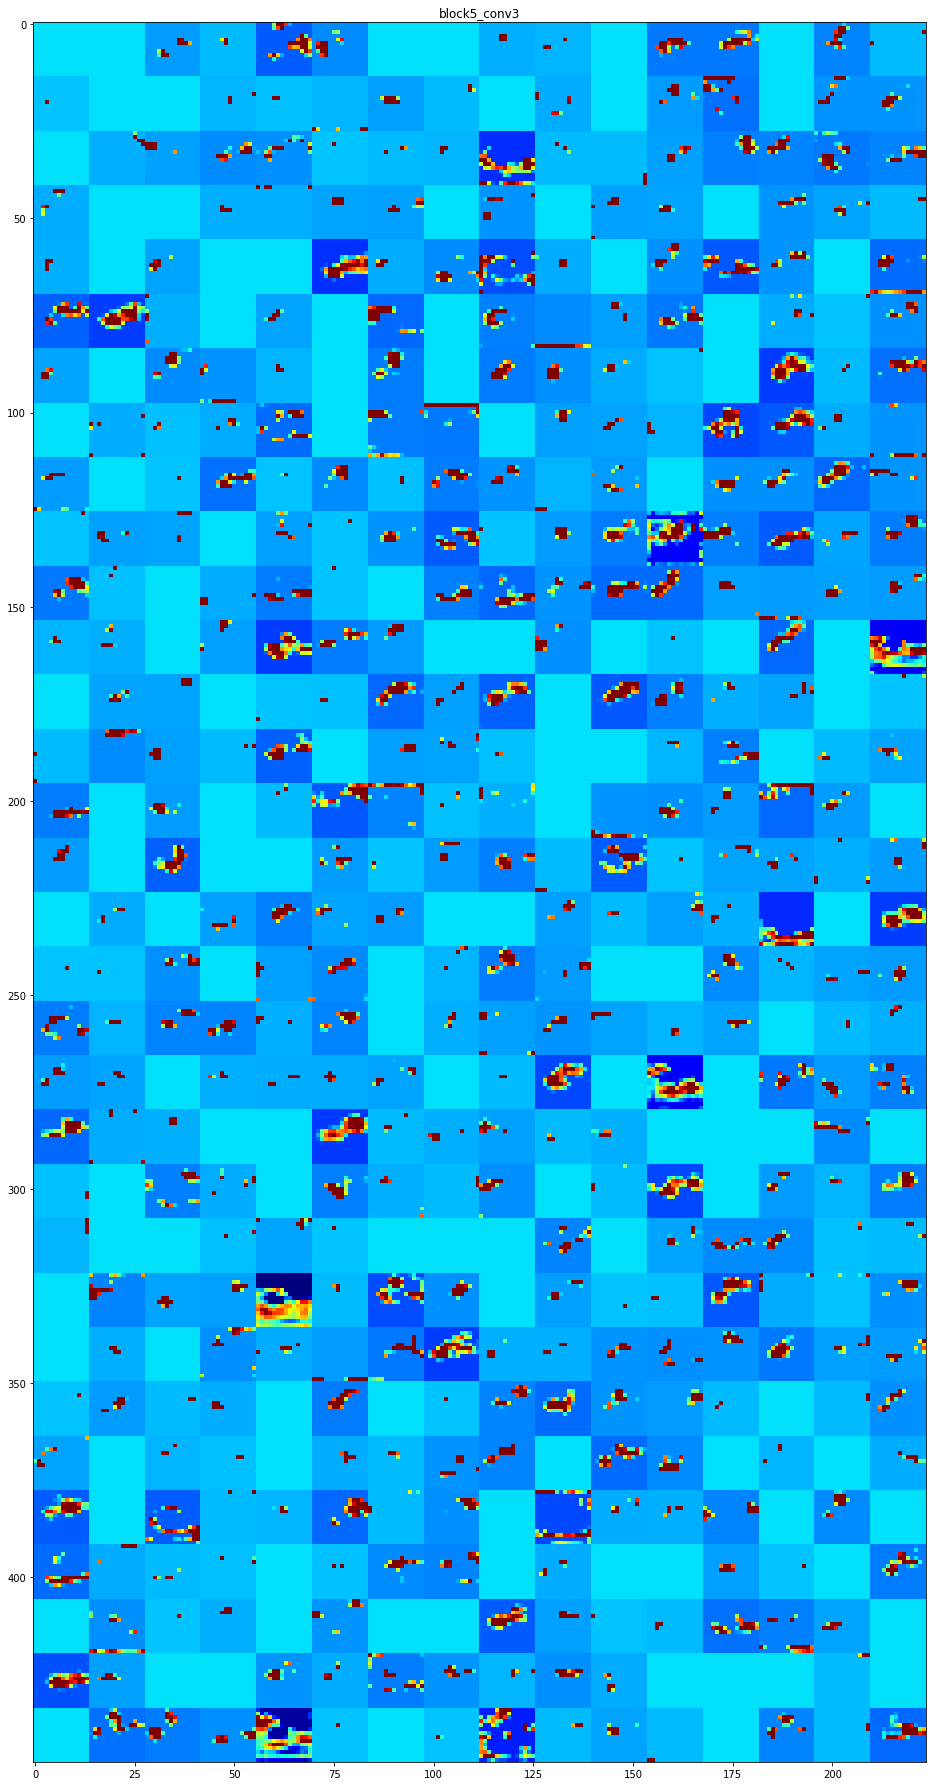

In [9]:
img_output = model.output[:, pred_label_keras]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(img_output, last_conv_layer.output)[0]

iterate = K.function([model.input], [grads[0], last_conv_layer.output[0]])
grads_value, conv_layer_output_value = iterate([img_tensor])

pooled_grads = np.mean(grads_value, axis=(0, 1))

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
heatmap = np.dot(conv_layer_output_value, pooled_grads)
heatmap = np.maximum(heatmap, 0)
if np.max(heatmap) != 0:
    heatmap /= np.max(heatmap)
ax1_handle = ax1.matshow(heatmap, cmap=plt.cm.jet)
fig1.colorbar(ax1_handle, ax=ax1, cmap=plt.cm.jet)

images_per_row = 16
n_features = conv_layer_output_value.shape[-1]
size = conv_layer_output_value.shape[0]
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = conv_layer_output_value[:, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        if channel_image.std() != 0:
            channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
scale = 1./size
fig2 = plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_title('block5_conv3')
ax2.grid(False)
ax2.imshow(display_grid, aspect='auto', cmap=plt.cm.jet)
plt.show(fig2)

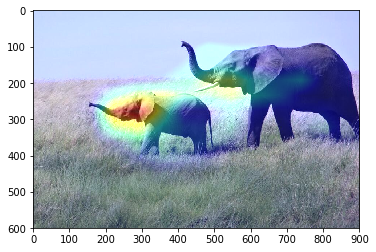

In [10]:
original_img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + original_img
superimposed_img_for_plt = superimposed_img[:,:,::-1]
superimposed_img_for_plt /= 255.
superimposed_img_for_plt = np.clip(superimposed_img_for_plt, 0, 1)
plt.imshow(superimposed_img_for_plt)

In [15]:
def show_layer_activation(img_tensor, model, pred_label_keras):
    img_output = model.output[:, pred_label_keras]
    last_conv_layer = model.get_layer('block5_conv3')
    last_conv_layer_weights,last_conv_layer_bias= model.get_layer('fc1').get_weights()
    grads = K.gradients(img_output, last_conv_layer.output)[0]
    
    iterate = K.function([model.input], [grads[0], last_conv_layer.output[0]])
    grads_value, conv_layer_output_value = iterate([img_tensor])
    
    conv_layer_output_value_max = conv_layer_output_value.max()
    conv_layer_output_value_min = conv_layer_output_value.min()
    conv_layer_output_value_mean = conv_layer_output_value.mean()
    conv_layer_output_value_median = np.median(conv_layer_output_value)
    print("conv_layer_output_value_max = " + str(conv_layer_output_value_max))
    print(np.where(conv_layer_output_value==conv_layer_output_value_max))
    print("conv_layer_output_value_min = " + str(conv_layer_output_value_min))
    print("conv_layer_output_value_mean = " + str(conv_layer_output_value_mean))
    print("conv_layer_output_value_median = " + str(conv_layer_output_value_median))
    
    print(conv_layer_output_value[:, :, 351])
    print(last_conv_layer_weights[351, :])
    print(grads_value[:, :, 351])

    pooled_grads = np.mean(grads_value, axis=(0, 1))
      
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 1, 1)
    heatmap = np.dot(conv_layer_output_value, pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    ax1_handle = ax1.matshow(heatmap, cmap=plt.cm.jet)
    fig1.colorbar(ax1_handle, ax=ax1, cmap=plt.cm.jet)

conv_layer_output_value_max = 261.79813
(array([3]), array([9]), array([351]))
conv_layer_output_value_min = 0.0
conv_layer_output_value_mean = 1.4504527
conv_layer_output_value_median = 0.0
[[  0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.          0.
    0.         17.784412  112.92053   132.02493    50.45959     0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.          0.
    0.         31.75108   193.4379    261.79813   167.71494     9.292431
    0.          0.       ]
 [  0.          0.          0.          0.         13.981844    1.108055
    0.         45.31499   184.8735    258.71207   205.57481    44.371098
    0.       

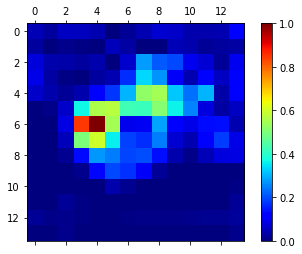

In [16]:
show_layer_activation(img_tensor, model, pred_label_keras)